# 사전설정

# 🎯 미션 정리: U-Net을 이용한 축구 경기 **Semantic Segmentation**

## 1) 🏁 미션 목표
- **목표:** 축구 경기 영상에서 **픽셀 단위로 객체를 분할(Semantic Segmentation)** 하는 모델 만들기  
- **모델:** `U-Net` 기반 세그멘테이션 네트워크 활용  
- **결과:** 각 픽셀이 **11개 클래스 중 하나**로 분류되도록 예측  
- **핵심 과제:** 데이터 전처리 → 모델 학습 → 예측 → 성능 평가 → 시각화  

---

## 2) ⚽ 데이터 구성

| 항목 | 내용 |
|------|------|
| **데이터 출처** | UEFA 슈퍼컵 2017 (레알 마드리드 vs 맨체스터 유나이티드) 하이라이트 영상 |
| **데이터 수** | 총 100장 프레임 (매 12번째 프레임 추출, 일부 대체 포함) |
| **작업 유형** | Semantic Segmentation (픽셀 단위 분류) |
| **클래스 (총 11개)** | ① Goal Bar (골대) <br> ② Referee (심판) <br> ③ Advertisement (광고판) <br> ④ Ground (잔디) <br> ⑤ Ball (축구공) <br> ⑥ Coaches & Officials (코칭 스태프) <br> ⑦ Audience (관중) <br> ⑧ Goalkeeper A <br> ⑨ Goalkeeper B <br> ⑩ Team A <br> ⑪ Team B |

---

## 3) 📂 제출 필수 포함 내용

| 구분 | 필수 내용 |
|------|------------|
| **분석 과정** | 데이터 로드 → 전처리 → 모델 학습 → 예측 → 성능 평가 |
| **모델 구성** | `U-Net` 기반 구조 (자체 설계 또는 개선형: `U-Net++`, `Attention U-Net` 가능) |
| **마크다운 설명** | 각 코드 셀마다 **의도, 알고리즘, 함수 설명**을 마크다운으로 명확히 작성 |
| **시각화 포함** | 예측 결과를 이미지로 시각화 (입력 이미지 / 예측 결과 / 실제 라벨 비교) |
| **성능 평가 지표** | `Cross Entropy Loss`, `Dice Loss` 등 Segmentation용 지표 활용 |
| **데이터 분할** | 학습용(train)과 테스트용(test)으로 분리 후 **테스트 성능 포함** |

---

## 4) 💡 성능 개선 아이디어

| 방법 | 설명 |
|------|------|
| **데이터 증강 (Data Augmentation)** | `Random Crop`, `Horizontal Flip`, `Color Jitter` 등 적용하여 다양한 경기 상황 대응 |
| **하이퍼파라미터 튜닝** | `learning rate`, `batch size`, `epoch` 조정으로 최적 성능 탐색 |
| **모델 개선** | `U-Net++`, `Attention U-Net`, `DeepLabV3+` 등 구조적 향상 시도 |

---

In [3]:
import os
import random
import collections
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms.v2 as v2
import torchvision.transforms.functional as F
from torchvision.tv_tensors import Image, Mask
from tqdm import tqdm

In [4]:
from google.colab import drive

# 드라이브 마운트
drive.mount('/content/drive')

# device 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Mounted at /content/drive
cuda


# 데이터 불러오기

In [5]:
#@title 케글 데이터 다운로드
import kagglehub

path = kagglehub.dataset_download("sadhliroomyprime/football-semantic-segmentation")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'football-semantic-segmentation' dataset.
Path to dataset files: /kaggle/input/football-semantic-segmentation


In [6]:
#@title 이미지 가져오기

image_folder = os.path.join(path, 'images')
file_list = os.listdir(image_folder)

# 출력물 확인
print(f'file_list: {len(file_list)}')
print(file_list)

file_list: 300
['Frame 1  (68).jpg___fuse.png', 'Frame 1  (96).jpg', 'Frame 1  (41).jpg', 'Frame 1  (85).jpg___fuse.png', 'Frame 1  (41).jpg___save.png', 'Frame 1  (48).jpg', 'Frame 1  (14).jpg___save.png', 'Frame 1  (83).jpg', 'Frame 1  (39).jpg___fuse.png', 'Frame 1  (47).jpg___fuse.png', 'Frame 1  (74).jpg', 'Frame 1  (24).jpg___fuse.png', 'Frame 1  (52).jpg', 'Frame 1  (63).jpg___fuse.png', 'Frame 1  (18).jpg___fuse.png', 'Frame 1  (72).jpg___save.png', 'Frame 1  (50).jpg___save.png', 'Frame 1  (16).jpg___fuse.png', 'Frame 1  (84).jpg___fuse.png', 'Frame 1  (57).jpg___save.png', 'Frame 1  (13).jpg___fuse.png', 'Frame 1  (37).jpg', 'Frame 1  (37).jpg___fuse.png', 'Frame 1  (80).jpg___fuse.png', 'Frame 1  (9).jpg___save.png', 'Frame 1  (100).jpg', 'Frame 1  (64).jpg', 'Frame 1  (70).jpg', 'Frame 1  (88).jpg___save.png', 'Frame 1  (7).jpg___save.png', 'Frame 1  (69).jpg', 'Frame 1  (1).jpg', 'Frame 1  (4).jpg', 'Frame 1  (19).jpg___save.png', 'Frame 1  (56).jpg', 'Frame 1  (24).jpg', 

In [7]:
#@title original/fuse/save 이미지

original_images = sorted([f for f in file_list if f.endswith('.jpg')])
fuse_images = sorted([f for f in file_list if 'fuse' in f])
save_images = sorted([f for f in file_list if 'save' in f])

print(original_images)
print(fuse_images)
print(save_images)

['Frame 1  (1).jpg', 'Frame 1  (10).jpg', 'Frame 1  (100).jpg', 'Frame 1  (11).jpg', 'Frame 1  (12).jpg', 'Frame 1  (13).jpg', 'Frame 1  (14).jpg', 'Frame 1  (15).jpg', 'Frame 1  (16).jpg', 'Frame 1  (17).jpg', 'Frame 1  (18).jpg', 'Frame 1  (19).jpg', 'Frame 1  (2).jpg', 'Frame 1  (20).jpg', 'Frame 1  (21).jpg', 'Frame 1  (22).jpg', 'Frame 1  (23).jpg', 'Frame 1  (24).jpg', 'Frame 1  (25).jpg', 'Frame 1  (26).jpg', 'Frame 1  (27).jpg', 'Frame 1  (28).jpg', 'Frame 1  (29).jpg', 'Frame 1  (3).jpg', 'Frame 1  (30).jpg', 'Frame 1  (31).jpg', 'Frame 1  (32).jpg', 'Frame 1  (33).jpg', 'Frame 1  (34).jpg', 'Frame 1  (35).jpg', 'Frame 1  (36).jpg', 'Frame 1  (37).jpg', 'Frame 1  (38).jpg', 'Frame 1  (39).jpg', 'Frame 1  (4).jpg', 'Frame 1  (40).jpg', 'Frame 1  (41).jpg', 'Frame 1  (42).jpg', 'Frame 1  (43).jpg', 'Frame 1  (44).jpg', 'Frame 1  (45).jpg', 'Frame 1  (46).jpg', 'Frame 1  (47).jpg', 'Frame 1  (48).jpg', 'Frame 1  (49).jpg', 'Frame 1  (5).jpg', 'Frame 1  (50).jpg', 'Frame 1  (51).j

In [8]:
#@title 사이즈 확인

def unique_sizes(image_files, image_folder):
    unique_sizes = set()                                        # 중복을 피하기 위해 set집합 형태로 저장

    for image in image_files:
        img_path = os.path.join(image_folder, image)            # 폴더+파일 이름합쳐서 전체경로 생성
        img = cv2.imread(img_path)                              # 이미지 파일 openCV로 읽기

        # 이미지 크기 확인
        height, width, channels = img.shape
        img_size = (height, width, channels)                    # 튜플 형태로 저장

        # 중복 건너뛰기
        if img_size in unique_sizes:
            continue

        # 새로운 크기라면 출력하고 set에 추가
        print(f'Image Size (H, W, C): {height}, {width}, {channels}')
        unique_sizes.add(img_size)

# Original 이미지 크기확인
print("Unique size of Original Image")
unique_sizes(original_images, image_folder)
# Fuse 이미지 크기확인
print("Unique size of Fuse Image")
unique_sizes(fuse_images, image_folder)
# Save 이미지 크기확인
print("Unique size of Save Image")
unique_sizes(save_images, image_folder)

Unique size of Original Image
Image Size (H, W, C): 1080, 1920, 3
Unique size of Fuse Image
Image Size (H, W, C): 1080, 1920, 3
Unique size of Save Image
Image Size (H, W, C): 1080, 1920, 3


In [9]:
#@title Image Pairing

image_pairs = []
for original_image in original_images:
    # 이름에서 '.jpg' 제거 / 기본이름만 남기기
    base_name = original_image.replace('.jpg', '')

    # fuse_images 중 base_name이 포함된 파일 찾기
    fuse_image = next((f for f in fuse_images if base_name in f), None)
    # save_images 중 base_name이 포함된 파일 찾기
    save_image = next((f for f in save_images if base_name in f), None)

    # fuse와 save에 둘다 존재하면 세트로 묶기
    if fuse_image and save_image:
        # 원본과 마스크 로드
        original_path = os.path.join(image_folder, original_image)
        fuse_path = os.path.join(image_folder, fuse_image)
        save_path = os.path.join(image_folder, save_image)

        orig = cv2.imread(original_path)
        fuse = cv2.imread(fuse_path)
        save = cv2.imread(save_path)

        # 이미지가 정상적으로 불러와 졌는지 확인
        if orig is not None and fuse is not None and save is not None:
            image_pairs.append((orig, fuse, save))

# 결과 확인 (이미지 세트 개수)
print(f'{len(image_pairs)} pairs')

100 pairs


5 samples


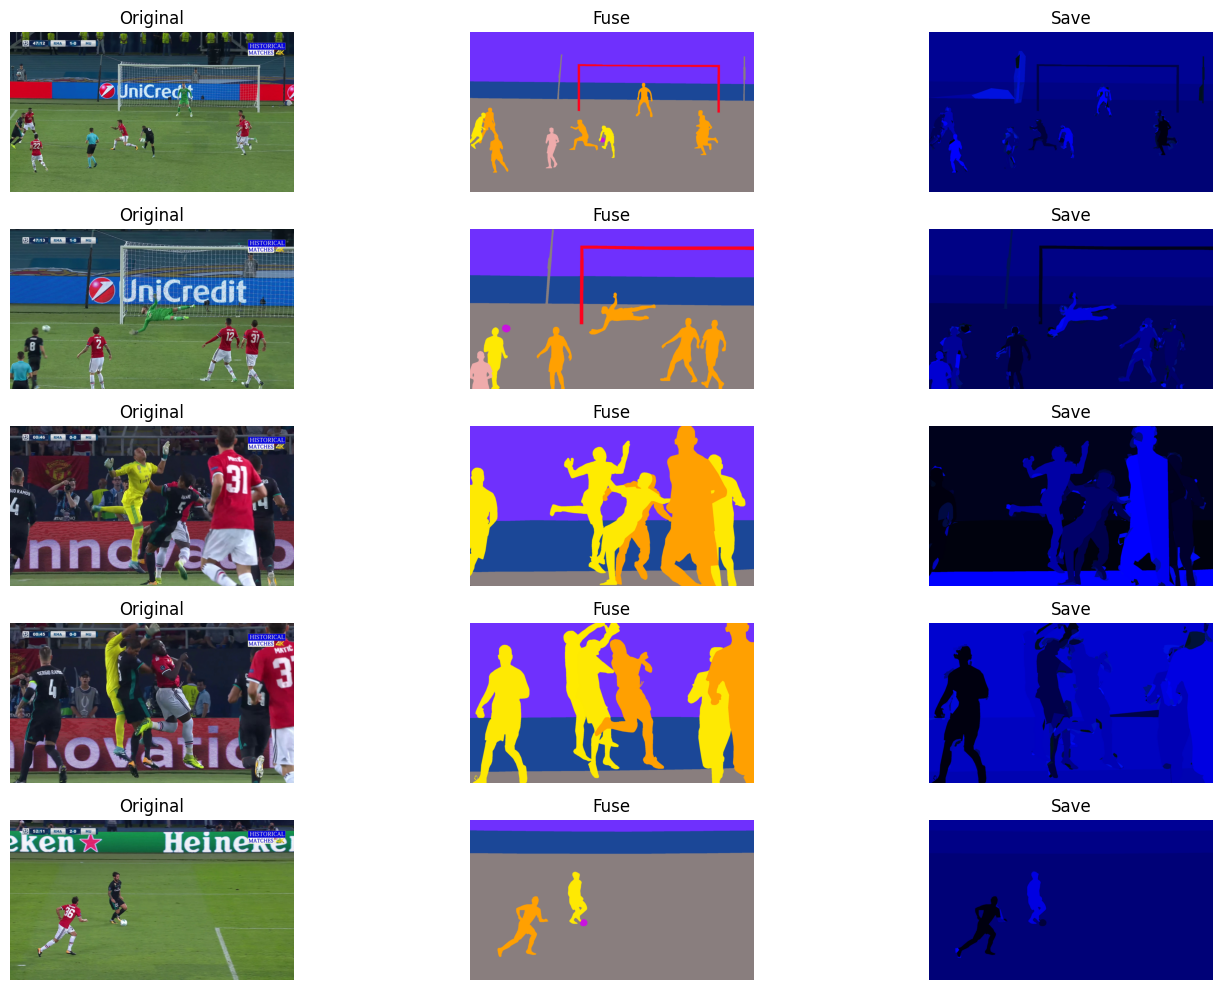

In [10]:
#@title 이미지 시각화

num_samples = 5
sample_image_pairs = random.sample(image_pairs, num_samples)

# 샘플 개수 확인
print(f'{len(sample_image_pairs)} samples')

# 시각화
fig, axes = plt.subplots(num_samples, 3, figsize=(15, 10))

# 한 줄씩 반복하면서 orig, fuse, save 순으로 표시
for i, (orig, fuse, save) in enumerate(sample_image_pairs):
    # 원본
    axes[i, 0].imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')

    # fuse
    axes[i, 1].imshow(cv2.cvtColor(fuse, cv2.COLOR_BGR2RGB))
    axes[i, 1].set_title('Fuse')
    axes[i, 1].axis('off')

    #save
    axes[i, 2].imshow(cv2.cvtColor(save, cv2.COLOR_BGR2RGB))
    axes[i, 2].set_title('Save')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

# 데이터 전처리

In [11]:
#@title 마스크 라벨링

# 데이터셋 전체의 고유 색상 수집
def get_unique_colors(image_folder, mask_files, max_classes=11):
    """
    데이터셋의 모든 마스크에서 고유한 색상을 추출하는 함수.

    Args:
        image_folder (str): 마스크 이미지가 있는 폴더 경로
        mask_files (list): 마스크 이미지 파일 리스트
        max_classes (int): 최대 클래스 개수 (기본값: 11)

    Returns:
        list: 고유한 색상 리스트 (최대 max_classes개)
    """
    color_set = set()               # 중복을 방지하기 위해 set 사용

    # 각 마스크 파일 순회
    for mask_file in mask_files:
        mask_path = os.path.join(image_folder, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        unique_colors, _ = np.unique(mask.reshape(-1, 3), axis=0, return_counts=True)
        # 모든 픽셀의 색상(H x W, 3)을 2차원 배열로 변환 후 >> np.=unique()로 고유 색상값 추출

        # 새로운 색상만 color_set에 추가
        for color in unique_colors:
            if tuple(color) not in color_set:
                color_set.add(tuple(color))

                # 최대 클래스 개수 초과 시 반복 중단
                if len(color_set) >= max_classes:
                    return list(color_set)

    # 모든 마스크 탐색 후 색상 리스트 반환
    return list(color_set)

# 모든 마스크 이미지에서 등장하는 색상 수집
unique_colors = get_unique_colors(image_folder, fuse_images)
print(f'Unique Colors: {len(unique_colors)}')

Unique Colors: 11


In [12]:
# 고유 색상을 숫자 라벨로 바꾸는 매핑 딕셔너리 생성
color_to_label = {color: idx for idx, color in enumerate(unique_colors)}
print(color_to_label)

{(np.uint8(238), np.uint8(171), np.uint8(171)): 0, (np.uint8(254), np.uint8(233), np.uint8(3)): 1, (np.uint8(0), np.uint8(0), np.uint8(0)): 2, (np.uint8(255), np.uint8(0), np.uint8(29)): 3, (np.uint8(111), np.uint8(48), np.uint8(253)): 4, (np.uint8(137), np.uint8(126), np.uint8(126)): 5, (np.uint8(27), np.uint8(71), np.uint8(151)): 6, (np.uint8(255), np.uint8(160), np.uint8(1)): 7, (np.uint8(201), np.uint8(19), np.uint8(223)): 8, (np.uint8(255), np.uint8(159), np.uint8(0)): 9, (np.uint8(255), np.uint8(235), np.uint8(0)): 10}


# 데이터셋




In [13]:
#@title 데이터셋 클래스 정의

class FootballDataset(Dataset):
    def __init__(self, image_files, mask_files, image_folder, color_to_label, transform=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.image_folder = image_folder
        self.color_to_label = color_to_label
        self.transform = transform

    def __len__(self):
        # 데이터셋의 총 이미지 개수 반환
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        하나의 이미지, 마스크 세트를 불러와서 전처리 후 반환하는 함수
        """
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        mask_path = os.path.join(self.image_folder, self.mask_files[idx])

        # 원본이미지 로드
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 마스크 로드
        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # transform이 없을 때
        if self.transform is None:
            # 크기 통일 및 정규화
            img = cv2.resize(img, (256, 256)) / 255.0           # 0~1 스케일로 정규화
            img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)       # (H, W, C) → (C, H, W)

            # 마스크는 색상 유지 + 최근접 보간으로 리사이즈
            mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
            mask = torch.tensor(mask, dtype=torch.uint8).permute(2, 0, 1)       # (H, W, C) → (C, H, W)

        else:
            # tv_tensor 사용
            img = Image(torch.from_numpy(img).permute(2, 0, 1))
            mask = Mask(torch.from_numpy(mask).permute(2, 0, 1))
            img, mask = self.transform(img, mask)

        # 색상 (RGB) >> 클래스 인데스 변환
        mask_np = mask.permute(1, 2, 0).numpy()                                 # (C, H, W) → (H, W, C)
        mask_class = np.zeros(mask_np.shape[:2], dtype=np.uint8)                # (H, W) 초기화
        # 모든 color_to_label 매핑에 대해 반복
        for color, label in self.color_to_label.items():
            # 해당 색상과 동일한 픽셀 위치에 클래스 번호 할당
            mask_class[np.all(mask_np == np.array(color), axis=-1)] = label     # 고정된 ID 사용

        # 클래스 번호를 tensor로 변환
        mask = torch.tensor(mask_class, dtype=torch.long)                       # (H, W)

        return img, mask

In [14]:
#@title train/val/test 데이터 분할

# 전체 데이터셋 크기
dataset_size = len(original_images)
trainval_size = int(0.9 * dataset_size)         # 90% train+validation
test_size = dataset_size - trainval_size        # 10% test

# zip()응 이용해 (img, mask) 튜플로 묶기
paired_files = list(zip(original_images, fuse_images))

# Train+Val / Test 랜덤하게 분할(9:1)
trainval_files, test_files = random_split(paired_files, [trainval_size, test_size])

# Train+Val 중에 다시 Train/Val 로 랜넘하게 분할
val_size = int(1/9 * trainval_size)             # trainval의 약 1/9(대략 10%)
train_size = trainval_size - val_size           # 나머지 train
train_files, val_files = random_split(trainval_files, [train_size, val_size])

# 분리된 리스트에서 이미지와 마스크 파일 각각 분리
train_image_files, train_mask_files = zip(*train_files)
val_image_files, val_mask_files = zip(*val_files)
test_image_files, test_mask_files = zip(*test_files)

# 데이터 정합성 확인
print("Checking Train images and masks")
for img, mask in zip(train_image_files, train_mask_files):
    base_img = img.split('.jpg')[0]                                             # 파일 이름에서 확장자 제거
    base_mask = mask.split('.jpg___fuse.png')[0]                                # 마스크 이름에서 확장자 제거
    if base_img != base_mask:
        print(f'Mismatch: {img} <-> {mask}')

print("Checking Val images and masks")
for img, mask in zip(val_image_files, val_mask_files):
    base_img = img.split(".jpg")[0]
    base_mask = mask.split(".jpg___fuse.png")[0]
    if base_img != base_mask:
        print(f"Mismatch: {img} <-> {mask}")

print("Checking Test images and masks")
for img, mask in zip(test_image_files, test_mask_files):
    base_img = img.split(".jpg")[0]
    base_mask = mask.split(".jpg___fuse.png")[0]
    if base_img != base_mask:
        print(f"Mismatch: {img} <-> {mask}")

Checking Train images and masks
Checking Val images and masks
Checking Test images and masks


In [15]:
#@title Dataset 인스턴스 생성

# 데이터셋
train_dataset = FootballDataset(train_image_files, train_mask_files, image_folder, color_to_label)
val_dataset = FootballDataset(val_image_files, val_mask_files, image_folder, color_to_label)
test_dataset = FootballDataset(test_image_files, test_mask_files, image_folder, color_to_label)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 데이터셋 크기 출력
print(f"Train Data: {len(train_dataset)}, Val Data: {len(val_dataset)}, Test Data: {len(test_dataset)}")

# 데이터로더에서 실제 1배치 꺼내 보기
for img, mask in train_loader:
    print(f"image size: {img.shape}")           # (batch, channel, height, width)
    print(f"mask size: {mask.shape}")           # (batch, height, width)
    break

Train Data: 80, Val Data: 10, Test Data: 10
image size: torch.Size([5, 3, 256, 256])
mask size: torch.Size([5, 256, 256])


- 데이터 다양성 확보 (Data Augmentation)

	•	축구 경기 영상은 조명, 각도, 카메라 방향 등 상황이 다양

	•	따라서 모델이 “한정된 이미지에만 과적합(overfitting)”되지 않도록 → RandomFlip, Rotation, Crop 같은 랜덤 변형을 줌
더 많은 상황을 학습하는 데이터셋 생성

In [16]:
#@title 트렌스폼 설정

# 학습용 트렌스폼
train_transform = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),                             # 50%확률로 좌우 반전
    v2.RandomVerticalFlip(p=0.2),                               # 20% 확률로 상하 반전
    v2.RandomRotation(degrees=10),                              # ±10도 이내 랜덤 회전
    v2.RandomResizedCrop(size=(256,256), scale=(0.8, 1.0)),     # 랜던 크롭 후 256 X 256으로 리사이즈
    v2.ToDtype(torch.float32, scale=True),
])

# 검증/테스트용 트렌스폼
valtest_transform = v2.Compose([
    v2.Resize((256, 256)),                                      # 크기만 256 X 256으로 통일
    v2.ToDtype(torch.float32, scale=True),                      # float32 변환 및 정규화
])

In [17]:
#@title 트랜스폼이 적용된 데이터셋 생성

train_transformed_dataset = FootballDataset(train_image_files, train_mask_files, image_folder, color_to_label, train_transform)
val_transformedtrain_transformed_dataset = FootballDataset(val_image_files, val_mask_files, image_folder, color_to_label, valtest_transform)
test_transformedtrain_transformed_dataset = FootballDataset(test_image_files, test_mask_files, image_folder, color_to_label, valtest_transform)

# 증강된 데이터셋을 데이터로더로 묶기
train_transformed_loader = DataLoader(train_transformed_dataset, batch_size=5, shuffle=True)
val_transformed_loader = DataLoader(val_transformedtrain_transformed_dataset, batch_size=5, shuffle=False)
test_transformed_loader = DataLoader(test_transformedtrain_transformed_dataset, batch_size=1, shuffle=False)

print(f'Train Data; {len(train_transformed_dataset)}, Val Data: {len(val_transformedtrain_transformed_dataset)}, test Data: {len(test_transformedtrain_transformed_dataset)}')

# 학습용 데이터로더에서 한 배치만 확인
for img, mask in train_transformed_loader:
    print(f"image size: {img.shape}")
    print(f"mask size: {mask.shape}")
    break

Train Data; 80, Val Data: 10, test Data: 10
image size: torch.Size([5, 3, 256, 256])
mask size: torch.Size([5, 256, 256])


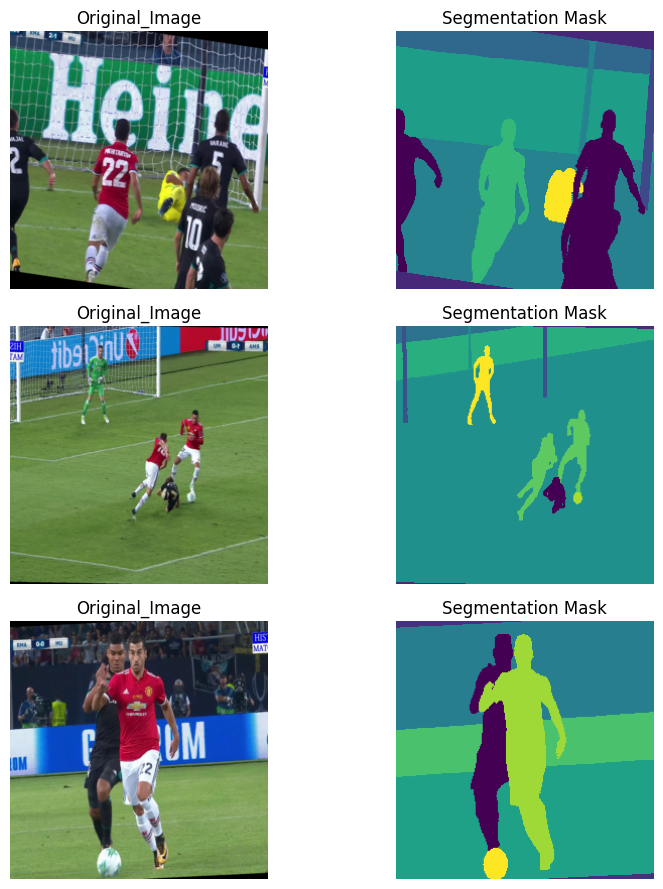

In [18]:
#@title 시각화
import matplotlib.pyplot as plt
import torchvision.transforms.v2.functional as F
from torchvision.utils import draw_segmentation_masks

# 데이터 로더에서 샘플을 가져와 이미지, 마스크, 오버레이 확인하는 함수
def visualize_samples(loader, num_samples=3):
    # 데이터로더에서 배치 한개 가져오기
    data_iter = iter(loader)
    imgs, masks = next(data_iter)

    fig, axs = plt.subplots(num_samples, 2, figsize=(9, num_samples * 3))
                            # 한 줄에 2개(원본, 마스크0 , 세로로 num_samples개

    for i in range(num_samples):
        img = imgs[i]
        mask = masks[i]

        # 이미지를 0~1 범위에서 0~255 범위로 스케일 변환
        img = F.to_dtype(img, torch.uint8, scale=True)

        # (C, H, W) → (H, W, C) 순서로 바꿔서 표시
        axs[i, 0].imshow(img.permute(1, 2, 0).numpy())
        axs[i, 0].set_title('Original_Image')
        axs[i, 0].axis('off')

        # 마스크를 그레이스케일로 시각화
        axs[i, 1].imshow(mask.numpy())
        axs[i, 1].set_title('Segmentation Mask')
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# 학습 데이터 트랜스폼 적용 확인
visualize_samples(train_transformed_loader)

In [19]:
# 데이터셋 샘플을 가져와 확인
for img, mask in train_transformed_loader:
    print(f"Image shape: {img.shape}")  # (5, 3, 256, 256)
    print(f"Mask shape: {mask.shape}")  # (5, 256, 256)

    # 이미지 값 범위 확인
    print(f"Image min: {img.min()}, max: {img.max()}")  # 0~1

    # 마스크 클래스 ID 확인
    print(f"Unique mask values: {torch.unique(mask)}")  # 0~10

    break  # 한 배치만 확인

Image shape: torch.Size([5, 3, 256, 256])
Mask shape: torch.Size([5, 256, 256])
Image min: 0.0, max: 1.0
Unique mask values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])


# 모델 저장 및 불러오기

In [20]:
#@title 환경 설정

if "COLAB_GPU" in os.environ:
    model_dir = "/content/drive/MyDrive/study/data/model_storage/"
else:
    model_dir = "./model_storage"

# 디렉토리 설정
os.makedirs(model_dir, exist_ok=True)                           # 이미 있으면 무시
print(f"Now using Model Directory: {model_dir}")

# 모델 경로 확인
def get_model_path(model_name):
    return os.path.join(model_dir, f'{model_name}.pth')

# 모델 저장하기
def save_model(model, model_name, optimizer, scheduler, epoch, best_metric):
    model_path = get_model_path(model_name)
    checkpoint = {
        "model": model.state_dict(),                            # 가중치
        "optimizer": optimizer.state_dict(),                    # 옵티마이저 상태
        "scheduler": scheduler.state_dict(),                    # 러닝레이트 스케쥴러 상태
        "epoch": epoch + 1,                                     # 다음 학습을 이어갈 epoch 번호
        "best_metric": best_metric                              # 최고 성능 기록
    }

    # 디스크에 저장
    torch.save(checkpoint, model_path)
    print(f"CheckPoint Svaed: {model_path}, Epoch: {epoch + 1}, Best Metric: {best_metric:.4f}")

# 모델 불러오기
def load_model(model, model_name, optimizer, scheduler):
    # 체크포인트에서 상태를 복원한다
    model_path = get_model_path(model_name)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 저장된 체크포인트가 없으면 새로 시작
    if not os.path.exists(model_path):
        print(f"No Checkpoint Found: {model_path}")
        return model.to(device), 0, float("inf")                # 'best_metric' 기준(최소/최대)에 따라 값 조정 필요

    # 체크 포인트 로드
    checkpoint = torch.load(model_path, map_location=device, weights_only=True)

    # 모델 가중치 복원
    model.load_state_dict(checkpoint["model"])
    epoch = checkpoint["epoch"]
    best_metric = checkpoint["best_metric"]

    # 평가시에는 옵티마이저/스케쥴러 부르지 않음
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint["optimizer"])
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint["scheduler"])

    print(f"Checkpoint Loaded: {model_path}, Epoch: {epoch}, Best Metric: {best_metric:.4f}")
    return model.to(device), epoch, best_metric

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Now using Model Directory: /content/drive/MyDrive/study/data/model_storage/
cuda


# 모델 학습 및 평가

In [21]:
!pip install torchinfo

In [34]:
#@title 학습 및 검증
from torchinfo import summary

def train_model(model, model_name, trainloader, valloader, criterion, optimizer, scheduler, num_epochs):
    model.to(device)
    # 기존에 저장된 체크포인트가 있으면 불러오기 (학습 이어하기)
    model, start_epoch, best_metric = load_model(model, model_name, optimizer, scheduler)

    print(f"Start with Epoch={start_epoch}, Best Metric={best_metric}")
    for epoch in range(start_epoch, num_epochs):
        # 학습 단계
        model.train()
        train_loss = 0
        avg_train_loss = 0              # 전체 학습 손실 누적 변수

        # 학습진행 (tqdm: 진행상황 출력)
        train_bar = tqdm(trainloader, desc=f"Training {epoch+1}/{num_epochs}")
        for images, masks in train_bar:
            images, masks = images.to(device), masks.to(device)
            masks = torch.clamp(masks, min=0, max=10)                           # 마스크 값 범위를 [0, 10]으로 제한(클래스 개수)

            optimizer.zero_grad()               # 이번 배치의 기울기 초기화
            outputs = model(images)             # 순전파: 모델 예측값 계산
            loss = criterion(outputs, masks)    # 손실 계산
            loss.backward()                     # 역전파: 오차를 기반으로 기울기 계산
            optimizer.step()                    # 가중치 업데이트

            train_loss += loss.item()           # 손실 누적
            train_bar.set_postfix({"loss": loss.item()})                        # tqdm 상태창에 현재 손실 표시

        avg_train_loss = train_loss / len(trainloader)                          # 에폭 단위 평균 손실 계산
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_train_loss:.4f}")\

        # 검증 단계
        model.eval()
        val_loss = 0
        avg_val_loss = 0
        val_bar = tqdm(valloader, desc=f"Validation {epoch + 1}/{num_epochs}")

        # 검증 중에는 기울기 계산 비활성화(메모리절약 및 속도 향상)
        with torch.no_grad():
            for images, masks in val_bar:
                images, masks = images.to(device), masks.to(device)
                masks = torch.clamp(masks, min=0, max=10)

                outputs = model(images)
                loss = criterion(outputs, masks)

                val_loss += loss.item()
                val_bar.set_postfix({"loss": loss.item()})

        avg_val_loss = val_loss / len(valloader)
        print(f"Validation Loss: {avg_val_loss}\n")

        # 학습률 스케쥴러 업데이트
        if scheduler is not None:
            current_lr = optimizer.param_groups[0]['lr']
            # ReduceLROnPlateau 스케줄러인 경우 → val_loss 기준으로 step
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(avg_val_loss)                                    # val_loss기준으로 판단
            else:
                scheduler.step()                                                # 일반 스케쥴러는 그냥 step()
            updated_lr = optimizer.param_groups[0]['lr']
            if updated_lr != current_lr:
                print(f"Learning Rate Updated: {current_lr:6f} -> {updated_lr:6f}")

        # 검증 손실이 이전보다 좋아지면 체크포인트 저장
        if avg_val_loss < best_metric:
            print(f"Best Validation Metric Updated: {best_metric:.4f} -> {avg_val_loss:.4f}")
            best_metric = avg_val_loss
            save_model(model, model_name, optimizer, scheduler, epoch, best_metric)

1. Focal Loss
    - Cross Entropy Loss의 개선된 버전
    - 클래스 불균형 문제 해결을 위해 도입
    - 쉽게 맞추는 샘플보다 어려운 샘플에 더 큰 가중치를 부여하여 모델이 어려운 샘플을 더 학습하도록 유도

2. Dice Loss
    - 불균형한 데이터에서 주로 사용되는 Segmentation Loss
    - IoU(Intersection over Union)와 유사한 방식으로 픽셀 간 유사성을 극대화
    - 작은 객체나 적은 픽셀 개수를 가진 클래스를 보다 잘 학습할 수 있도록 함

3. Hybrid Loss(Focal Loss + Dice Loss)
    - 두 가지 손실을 50:50 비율로 결합하여 균형 잡힌 학습을 유도

### 세그멘텐이션 손실 3종

In [35]:
#@title Focal Loss

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        """
        Focal Loss
        - alpha: 양/음성(혹은 소수 클래스) 쪽에 주는 가중치(클래스 불균형 보정)
        - gamma: 쉬운 샘플을 얼마나 눌러줄지(큰 값일수록 '어려운' 샘플에 집중)
        기대 입력:
          inputs: (B, C, H, W) 로짓(logits)  # softmax 미적용!
          targets: (B, H, W) 클래스 인덱스(0~num_classes-1), dtype=torch.long
        """
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss()                              # CE는 내부에서 log-softmax 처리

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)                           # 스칼라 평균 손실
        pt = torch.exp(-ce_loss)                                          # pt = exp(-CE) = 얘측이 맞을 수록 1에 가까움
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss        # 쉬운 샘플(pt≈1)은 가볍게
        return focal_loss.mean()


In [36]:
#@title Dice Loss

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6, num_classes=11):
        """
        Dice Loss (멀티클래스)
        - overlap(겹침)을 직접 최적화 → 경계/소수 클래스에 유리
        - smooth: 0으로 나누기 방지용 작은 값
        기대 입력:
          inputs: (B, C, H, W) 로짓(logits)
          targets: (B, H, W) long (클래스 인덱스)
        """
        super().__init__()
        self.smooth = smooth
        self.num_classes = num_classes

    def forward(self, inputs, targets):
        # logits >> 확률 변환
        inputs = torch.softmax(inputs, dim=1)

        # target을 원-핫으로: (B, H, W) → (B, H, W, C) → (B, C, H, W)
        targets = torch.nn.functional.one_hot(targets, num_classes=self.num_classes).permute(0, 3, 1, 2).float()

        # 클래스별 Dice계산
        intersection = (inputs * targets).sum(dim=(2, 3))
        dice_score = (2. * intersection + self.smooth) / (inputs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3)) + self.smooth)
        return 1 - dice_score.mean()            # Dice Score를 Loss로 변환

In [37]:
#@title HybridLoss

class HybridLoss(nn.Module):
    def __init__(self, alpha=0.5, num_classes=11):
        super().__init__()
        """
        Hybrid = alpha * Focal + (1 - alpha) * Dice
        - alpha가 클수록 Focal 비중↑ (클래스 불균형/어려운 픽셀 집중)
        - alpha가 작을수록 Dice 비중↑ (겹침 최적화/경계에 강함)
        """
        self.focal = FocalLoss()
        self.dice = DiceLoss(num_classes=num_classes)
        self.alpha = alpha      # Focal Loss 가중치

    def forward(self, inputs, targets):
        return self.alpha * self.focal(inputs, targets) + (1 - self.alpha) * self.dice(inputs, targets)

### UNet

In [38]:
#@title U-Net 모델정의
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, num_classes=11):
        super().__init__()

        # 반복되는 Conv/BatchNorm/ReLU 블록을 함수로 정의
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), # 특징 추출(3X3 필터)
                nn.BatchNorm2d(out_channels),                                   # 배치 단위로 정규화 >> 학습인정과 빠른수렴
                nn.ReLU(inplace=True),                                          # 비선형성 추가(음수는 0으로)

                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),                                   # 정규화 반복(깊은 특징 안정화)
                nn.ReLU(inplace=True),                                          # 활성화
            )

        # 인코더: 입력 이미지를 점점 압축하며 특징 추출
        self.encoder1 = conv_block(3, 64)                  # RGB >> 64ch
        self.encoder2 = conv_block(64, 128)                # 64ch >> 128ch
        self.encoder3 = conv_block(128, 256)               # 128ch >> 256ch
        self.encoder4 = conv_block(256, 512)               # 256ch >> 512ch

        self.pool = nn.MaxPool2d(2, 2)                     # 해상도 절반, 강한 특징만 남기

        # 보틀넥: 가장 압축된 단계
        self.bottleneck = conv_block(512, 1024)            # 512ch >> 1024ch

        # 디코더: 압축된 특징을 원본 해상도로 복원
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)   # 업샘플링 2배
        self.decoder4 = conv_block(1024, 512)                                   # upconv 결과 + encoder4 결합 후 복원

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        # 픽셀당 클래스 예측용 1x1 컨볼루션
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # 인코딩
        e1 = self.encoder1(x)               # (B, 64, H, W)
        e2 = self.encoder2(self.pool(e1))   # (B, 128, H/2, W/2)
        e3 = self.encoder3(self.pool(e2))   # (B, 256, H/4, W/4)
        e4 = self.encoder4(self.pool(e3))   # (B, 512, H/8, W/8)

        # 보틀넷
        b = self.bottleneck(self.pool(e4))  # (B, 1024, H/16, W/16)

        # 디코딩
        d4 = self.upconv4(b)                # 업샘플 (B, 512, H/8, W/8)
        d4 = torch.cat((d4, e4), dim=1)     # 인코더 e4와 연결 (스킵)
        d4 = self.decoder4(d4)              # 복원 (B, 512, H/8, W/8)

        d3 = self.upconv3(d4)               # 업샘플 (B, 256, H/4, W/4)
        d3 = torch.cat((d3, e3), dim=1)     # 인코더 e3 결합
        d3 = self.decoder3(d3)              # 복원 (B, 256, H/4, W/4)

        d2 = self.upconv2(d3)               # 업샘플 (B, 128, H/2, W/2)
        d2 = torch.cat((d2, e2), dim=1)     # 인코더 e2 결합
        d2 = self.decoder2(d2)              # 복원 (B, 128, H/2, W/2)

        d1 = self.upconv1(d2)               # 업샘플 (B, 64, H, W)
        d1 = torch.cat((d1, e1), dim=1)     # 인코더 e2 결합
        d1 = self.decoder1(d1)              # 복원 (B, 64, H, W)

        # 최종 출력
        return self.final_conv(d1)          # (B, num_classes, H, W)

In [39]:
#@title 모델 학습

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# U-Net 모델 생성 및 디바이스로 이동
model = UNet(num_classes=11).to(device)

# 총 학습 epoch수
num_epochs = 35

# 손실함수 : HybridLoss = α*Focal + (1-α)*Dice
criterion = HybridLoss(alpha=0.5, num_classes=11)
# 최적화 Adam
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)         # weight_decay=1e-4: L2 정규화(가중치 감쇠)로 과적합 방지
# 스케쥴러
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)     # 학습 초기에 비교적 큰 LR에서 시작 >> 코사인 곡선으로 점차 줄여 마지막엔 1e-6 근처까지

# 학습 루프
train_model(model, "Baseline_UNet", train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

No Checkpoint Found: /content/drive/MyDrive/study/data/model_storage/Baseline_UNet.pth
Start with Epoch=0, Best Metric=inf


Training 1/35: 100%|██████████| 16/16 [00:09<00:00,  1.74it/s, loss=0.442]


Epoch [1/35], Loss: 0.5196


Validation 1/35: 100%|██████████| 2/2 [00:00<00:00,  2.94it/s, loss=0.472]


Validation Loss: 0.4730323851108551

Learning Rate Updated: 0.005000 -> 0.004990
Best Validation Metric Updated: inf -> 0.4730
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Baseline_UNet.pth, Epoch: 1, Best Metric: 0.4730


Training 2/35: 100%|██████████| 16/16 [00:09<00:00,  1.73it/s, loss=0.429]


Epoch [2/35], Loss: 0.4229


Validation 2/35: 100%|██████████| 2/2 [00:00<00:00,  2.08it/s, loss=0.446]


Validation Loss: 0.4636051803827286

Learning Rate Updated: 0.004990 -> 0.004960
Best Validation Metric Updated: 0.4730 -> 0.4636
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Baseline_UNet.pth, Epoch: 2, Best Metric: 0.4636


Training 3/35: 100%|██████████| 16/16 [00:09<00:00,  1.61it/s, loss=0.39]


Epoch [3/35], Loss: 0.4081


Validation 3/35: 100%|██████████| 2/2 [00:00<00:00,  3.04it/s, loss=0.436]


Validation Loss: 0.4323682188987732

Learning Rate Updated: 0.004960 -> 0.004910
Best Validation Metric Updated: 0.4636 -> 0.4324
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Baseline_UNet.pth, Epoch: 3, Best Metric: 0.4324


Training 4/35: 100%|██████████| 16/16 [00:09<00:00,  1.73it/s, loss=0.373]


Epoch [4/35], Loss: 0.3851


Validation 4/35: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s, loss=0.403]


Validation Loss: 0.3983929604291916

Learning Rate Updated: 0.004910 -> 0.004841
Best Validation Metric Updated: 0.4324 -> 0.3984
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Baseline_UNet.pth, Epoch: 4, Best Metric: 0.3984


Training 5/35: 100%|██████████| 16/16 [00:09<00:00,  1.75it/s, loss=0.339]


Epoch [5/35], Loss: 0.3672


Validation 5/35: 100%|██████████| 2/2 [00:00<00:00,  2.48it/s, loss=0.434]


Validation Loss: 0.42776449024677277

Learning Rate Updated: 0.004841 -> 0.004752


Training 6/35: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s, loss=0.352]


Epoch [6/35], Loss: 0.3582


Validation 6/35: 100%|██████████| 2/2 [00:00<00:00,  2.99it/s, loss=0.432]


Validation Loss: 0.42319099605083466

Learning Rate Updated: 0.004752 -> 0.004646


Training 7/35: 100%|██████████| 16/16 [00:09<00:00,  1.74it/s, loss=0.309]


Epoch [7/35], Loss: 0.3475


Validation 7/35: 100%|██████████| 2/2 [00:00<00:00,  3.00it/s, loss=0.394]


Validation Loss: 0.3830782473087311

Learning Rate Updated: 0.004646 -> 0.004523
Best Validation Metric Updated: 0.3984 -> 0.3831
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Baseline_UNet.pth, Epoch: 7, Best Metric: 0.3831


Training 8/35: 100%|██████████| 16/16 [00:09<00:00,  1.74it/s, loss=0.352]


Epoch [8/35], Loss: 0.3312


Validation 8/35: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s, loss=0.384]


Validation Loss: 0.3706533908843994

Learning Rate Updated: 0.004523 -> 0.004383
Best Validation Metric Updated: 0.3831 -> 0.3707
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Baseline_UNet.pth, Epoch: 8, Best Metric: 0.3707


Training 9/35: 100%|██████████| 16/16 [00:09<00:00,  1.72it/s, loss=0.307]


Epoch [9/35], Loss: 0.3190


Validation 9/35: 100%|██████████| 2/2 [00:00<00:00,  2.43it/s, loss=0.363]


Validation Loss: 0.356533944606781

Learning Rate Updated: 0.004383 -> 0.004228
Best Validation Metric Updated: 0.3707 -> 0.3565
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Baseline_UNet.pth, Epoch: 9, Best Metric: 0.3565


Training 10/35: 100%|██████████| 16/16 [00:08<00:00,  1.78it/s, loss=0.31]


Epoch [10/35], Loss: 0.3222


Validation 10/35: 100%|██████████| 2/2 [00:01<00:00,  1.36it/s, loss=0.394]


Validation Loss: 0.3680887371301651

Learning Rate Updated: 0.004228 -> 0.004059


Training 11/35: 100%|██████████| 16/16 [00:10<00:00,  1.46it/s, loss=0.359]


Epoch [11/35], Loss: 0.3093


Validation 11/35: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s, loss=0.323]


Validation Loss: 0.3048497289419174

Learning Rate Updated: 0.004059 -> 0.003877
Best Validation Metric Updated: 0.3565 -> 0.3048
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Baseline_UNet.pth, Epoch: 11, Best Metric: 0.3048


Training 12/35: 100%|██████████| 16/16 [00:09<00:00,  1.73it/s, loss=0.276]


Epoch [12/35], Loss: 0.3025


Validation 12/35: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s, loss=0.356]


Validation Loss: 0.33085401356220245

Learning Rate Updated: 0.003877 -> 0.003685


Training 13/35: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s, loss=0.275]


Epoch [13/35], Loss: 0.3053


Validation 13/35: 100%|██████████| 2/2 [00:00<00:00,  2.43it/s, loss=0.407]


Validation Loss: 0.3844296485185623

Learning Rate Updated: 0.003685 -> 0.003483


Training 14/35: 100%|██████████| 16/16 [00:09<00:00,  1.62it/s, loss=0.286]


Epoch [14/35], Loss: 0.2942


Validation 14/35: 100%|██████████| 2/2 [00:00<00:00,  3.02it/s, loss=0.325]


Validation Loss: 0.31940925121307373

Learning Rate Updated: 0.003483 -> 0.003273


Training 15/35: 100%|██████████| 16/16 [00:09<00:00,  1.73it/s, loss=0.317]


Epoch [15/35], Loss: 0.2961


Validation 15/35: 100%|██████████| 2/2 [00:00<00:00,  3.01it/s, loss=0.336]


Validation Loss: 0.33667057752609253

Learning Rate Updated: 0.003273 -> 0.003057


Training 16/35: 100%|██████████| 16/16 [00:08<00:00,  1.82it/s, loss=0.258]


Epoch [16/35], Loss: 0.2807


Validation 16/35: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s, loss=0.307]


Validation Loss: 0.28673961758613586

Learning Rate Updated: 0.003057 -> 0.002836
Best Validation Metric Updated: 0.3048 -> 0.2867
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Baseline_UNet.pth, Epoch: 16, Best Metric: 0.2867


Training 17/35: 100%|██████████| 16/16 [00:10<00:00,  1.59it/s, loss=0.271]


Epoch [17/35], Loss: 0.2750


Validation 17/35: 100%|██████████| 2/2 [00:01<00:00,  1.37it/s, loss=0.335]


Validation Loss: 0.3211475610733032

Learning Rate Updated: 0.002836 -> 0.002613


Training 18/35: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s, loss=0.277]


Epoch [18/35], Loss: 0.2745


Validation 18/35: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s, loss=0.39]


Validation Loss: 0.36856840550899506

Learning Rate Updated: 0.002613 -> 0.002388


Training 19/35: 100%|██████████| 16/16 [00:11<00:00,  1.35it/s, loss=0.241]


Epoch [19/35], Loss: 0.2737


Validation 19/35: 100%|██████████| 2/2 [00:01<00:00,  1.69it/s, loss=0.299]


Validation Loss: 0.28211143612861633

Learning Rate Updated: 0.002388 -> 0.002165
Best Validation Metric Updated: 0.2867 -> 0.2821
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Baseline_UNet.pth, Epoch: 19, Best Metric: 0.2821


Training 20/35: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=0.265]


Epoch [20/35], Loss: 0.2679


Validation 20/35: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it, loss=0.302]


Validation Loss: 0.2876068204641342

Learning Rate Updated: 0.002165 -> 0.001944


Training 21/35: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it, loss=0.246]


Epoch [21/35], Loss: 0.2570


Validation 21/35: 100%|██████████| 2/2 [00:01<00:00,  1.83it/s, loss=0.284]


Validation Loss: 0.2651429697871208

Learning Rate Updated: 0.001944 -> 0.001728
Best Validation Metric Updated: 0.2821 -> 0.2651
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Baseline_UNet.pth, Epoch: 21, Best Metric: 0.2651


Training 22/35: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s, loss=0.267]


Epoch [22/35], Loss: 0.2609


Validation 22/35: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.299]


Validation Loss: 0.2778236120939255

Learning Rate Updated: 0.001728 -> 0.001518


Training 23/35: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s, loss=0.253]


Epoch [23/35], Loss: 0.2546


Validation 23/35: 100%|██████████| 2/2 [00:01<00:00,  1.72it/s, loss=0.311]


Validation Loss: 0.2915719896554947

Learning Rate Updated: 0.001518 -> 0.001316


Training 24/35: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s, loss=0.266]


Epoch [24/35], Loss: 0.2566


Validation 24/35: 100%|██████████| 2/2 [00:00<00:00,  2.58it/s, loss=0.288]


Validation Loss: 0.265822634100914

Learning Rate Updated: 0.001316 -> 0.001124


Training 25/35: 100%|██████████| 16/16 [00:10<00:00,  1.52it/s, loss=0.256]


Epoch [25/35], Loss: 0.2497


Validation 25/35: 100%|██████████| 2/2 [00:01<00:00,  1.27it/s, loss=0.271]


Validation Loss: 0.24943958222866058

Learning Rate Updated: 0.001124 -> 0.000942
Best Validation Metric Updated: 0.2651 -> 0.2494
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Baseline_UNet.pth, Epoch: 25, Best Metric: 0.2494


Training 26/35: 100%|██████████| 16/16 [00:08<00:00,  1.79it/s, loss=0.257]


Epoch [26/35], Loss: 0.2416


Validation 26/35: 100%|██████████| 2/2 [00:00<00:00,  2.82it/s, loss=0.28]


Validation Loss: 0.2543627992272377

Learning Rate Updated: 0.000942 -> 0.000773


Training 27/35: 100%|██████████| 16/16 [00:12<00:00,  1.26it/s, loss=0.235]


Epoch [27/35], Loss: 0.2418


Validation 27/35: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s, loss=0.293]


Validation Loss: 0.2675076872110367

Learning Rate Updated: 0.000773 -> 0.000618


Training 28/35: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s, loss=0.251]


Epoch [28/35], Loss: 0.2389


Validation 28/35: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s, loss=0.27]


Validation Loss: 0.25145331025123596

Learning Rate Updated: 0.000618 -> 0.000478


Training 29/35: 100%|██████████| 16/16 [00:11<00:00,  1.39it/s, loss=0.201]


Epoch [29/35], Loss: 0.2367


Validation 29/35: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s, loss=0.262]


Validation Loss: 0.2385343238711357

Learning Rate Updated: 0.000478 -> 0.000355
Best Validation Metric Updated: 0.2494 -> 0.2385
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Baseline_UNet.pth, Epoch: 29, Best Metric: 0.2385


Training 30/35: 100%|██████████| 16/16 [00:11<00:00,  1.40it/s, loss=0.254]


Epoch [30/35], Loss: 0.2359


Validation 30/35: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s, loss=0.261]


Validation Loss: 0.23773983120918274

Learning Rate Updated: 0.000355 -> 0.000249
Best Validation Metric Updated: 0.2385 -> 0.2377
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Baseline_UNet.pth, Epoch: 30, Best Metric: 0.2377


Training 31/35: 100%|██████████| 16/16 [00:09<00:00,  1.66it/s, loss=0.25]


Epoch [31/35], Loss: 0.2343


Validation 31/35: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.258]


Validation Loss: 0.23502016067504883

Learning Rate Updated: 0.000249 -> 0.000160
Best Validation Metric Updated: 0.2377 -> 0.2350
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Baseline_UNet.pth, Epoch: 31, Best Metric: 0.2350


Training 32/35: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s, loss=0.425]


Epoch [32/35], Loss: 0.2430


Validation 32/35: 100%|██████████| 2/2 [00:00<00:00,  2.89it/s, loss=0.258]


Validation Loss: 0.23552995175123215

Learning Rate Updated: 0.000160 -> 0.000091


Training 33/35: 100%|██████████| 16/16 [00:12<00:00,  1.30it/s, loss=0.282]


Epoch [33/35], Loss: 0.2315


Validation 33/35: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s, loss=0.257]


Validation Loss: 0.2348240613937378

Learning Rate Updated: 0.000091 -> 0.000041
Best Validation Metric Updated: 0.2350 -> 0.2348
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Baseline_UNet.pth, Epoch: 33, Best Metric: 0.2348


Training 34/35: 100%|██████████| 16/16 [00:10<00:00,  1.59it/s, loss=0.269]


Epoch [34/35], Loss: 0.2322


Validation 34/35: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, loss=0.256]


Validation Loss: 0.23375973105430603

Learning Rate Updated: 0.000041 -> 0.000011
Best Validation Metric Updated: 0.2348 -> 0.2338
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Baseline_UNet.pth, Epoch: 34, Best Metric: 0.2338


Training 35/35: 100%|██████████| 16/16 [00:11<00:00,  1.42it/s, loss=0.243]


Epoch [35/35], Loss: 0.2307


Validation 35/35: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s, loss=0.255]


Validation Loss: 0.233530692756176

Learning Rate Updated: 0.000011 -> 0.000001
Best Validation Metric Updated: 0.2338 -> 0.2335
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Baseline_UNet.pth, Epoch: 35, Best Metric: 0.2335


In [40]:
#@title 시각화

# 고정된 컬러맵 설정
fixed_colors = list(mcolors.TABLEAU_COLORS.values())           # matplotlib "tab10" 색상10개 사용
label_colors = {label: fixed_colors[i % len(fixed_colors)] for i, label in enumerate(range(11))}    # 0~10 라벨에 색 배정(10색 순환)
cmap_fixed = mcolors.ListedColormap([label_colors[label] for label in sorted(label_colors.keys())]) # 고정 colormap 생성

# 모델 로드 및 예측 준비
model, _, _ = load_model(model, "Baseline_UNet", optimizer, scheduler)

with torch.no_grad():                               # 추론모드: 그라디언트 계산 끔
    test_iter = iter(test_loader)                   # DataLoader >> Iterator
    plt.figure(figsize=(15, 40))

    plot_index = 1
    test_loss = 0
    for images, masks in test_iter:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)                                                 # 순전파>>logit (B, C, H, W)\
        loss = criterion(outputs, masks)                                        # 테스트 손실 (같은 criterion으로 평가)
        test_loss += loss.item()

        # 예측 마스크 (softmax로 확률화 >> argmax로 클래스 선택)
        pred_masks = torch.argmax(torch.softmax(outputs, dim=1), dim=1).cpu().numpy()

        for b in range(images.size(0)):
            # 원본이미지
            plt.subplot(10, 3, plot_index)
            plt.imshow(images[b].cpu().permute(1, 2, 0))                        # (C,H,W)>>(H,W,C)로 전치
            plt.title("Original Image")
            plt.axis('off')
            plot_index += 1

            # Ground Truth 마스크 출력
            plt.subplot(10, 3, plot_index)
            plt.imshow(masks[b].cpu().numpy(), cmap=cmap_fixed, vmin=0, vmax=10)    # 같은 팔레트 보장
            plt.title("Ground Truth Mask")
            plt.axis('off')
            plot_index += 1

            # Predicted 마스크 출력
            plt.subplot(10, 3, plot_index)
            plt.imshow(pred_masks[b], cmap=cmap_fixed, vmin=0, vmax=10)     # 같은 팔레트 보장
            plt.title("Predicted Mask")
            plt.axis('off')
            plot_index += 1

            if plot_index > 10 * 3:                 # 10개 샘픙(=30 서브플롯) 까지만 시각화
                break
        if plot_index > 10 * 3:
            break

    avg_test_loss = test_loss / len(test_loader)
    print(f"Test Loss: {avg_test_loss}")

    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Transformed Data

In [44]:
#@title 모델 학습

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(num_classes=11).to(device)

num_epochs = 51
criterion = HybridLoss(alpha=0.5, num_classes=11)
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=1e-4, min_lr=1e-6)

train_model(model, "Transformed_UNet", train_transformed_loader, val_transformed_loader, criterion, optimizer, scheduler, num_epochs)

No Checkpoint Found: /content/drive/MyDrive/study/data/model_storage/Transformed_UNet.pth
Start with Epoch=0, Best Metric=inf


Training 1/51: 100%|██████████| 16/16 [00:24<00:00,  1.53s/it, loss=0.401]


Epoch [1/51], Loss: 0.4780


Validation 1/51: 100%|██████████| 2/2 [00:00<00:00,  2.83it/s, loss=0.691]


Validation Loss: 0.6959340274333954

Best Validation Metric Updated: inf -> 0.6959
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Transformed_UNet.pth, Epoch: 1, Best Metric: 0.6959


Training 2/51: 100%|██████████| 16/16 [00:27<00:00,  1.71s/it, loss=0.359]


Epoch [2/51], Loss: 0.3870


Validation 2/51: 100%|██████████| 2/2 [00:00<00:00,  2.78it/s, loss=0.442]


Validation Loss: 0.4380715936422348

Best Validation Metric Updated: 0.6959 -> 0.4381
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Transformed_UNet.pth, Epoch: 2, Best Metric: 0.4381


Training 3/51: 100%|██████████| 16/16 [00:30<00:00,  1.88s/it, loss=0.345]


Epoch [3/51], Loss: 0.3731


Validation 3/51: 100%|██████████| 2/2 [00:00<00:00,  2.42it/s, loss=0.429]


Validation Loss: 0.42079922556877136

Best Validation Metric Updated: 0.4381 -> 0.4208
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Transformed_UNet.pth, Epoch: 3, Best Metric: 0.4208


Training 4/51: 100%|██████████| 16/16 [00:30<00:00,  1.89s/it, loss=0.413]


Epoch [4/51], Loss: 0.3588


Validation 4/51: 100%|██████████| 2/2 [00:01<00:00,  1.82it/s, loss=0.408]


Validation Loss: 0.39788947999477386

Best Validation Metric Updated: 0.4208 -> 0.3979
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Transformed_UNet.pth, Epoch: 4, Best Metric: 0.3979


Training 5/51: 100%|██████████| 16/16 [00:30<00:00,  1.89s/it, loss=0.34]


Epoch [5/51], Loss: 0.3556


Validation 5/51: 100%|██████████| 2/2 [00:00<00:00,  2.41it/s, loss=0.427]


Validation Loss: 0.42059391736984253



Training 6/51: 100%|██████████| 16/16 [00:26<00:00,  1.67s/it, loss=0.343]


Epoch [6/51], Loss: 0.3374


Validation 6/51: 100%|██████████| 2/2 [00:00<00:00,  2.91it/s, loss=0.415]


Validation Loss: 0.417977899312973



Training 7/51: 100%|██████████| 16/16 [00:24<00:00,  1.53s/it, loss=0.312]


Epoch [7/51], Loss: 0.3199


Validation 7/51: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s, loss=0.366]


Validation Loss: 0.35438647866249084

Best Validation Metric Updated: 0.3979 -> 0.3544
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Transformed_UNet.pth, Epoch: 7, Best Metric: 0.3544


Training 8/51: 100%|██████████| 16/16 [00:29<00:00,  1.85s/it, loss=0.298]


Epoch [8/51], Loss: 0.2996


Validation 8/51: 100%|██████████| 2/2 [00:00<00:00,  2.49it/s, loss=0.427]


Validation Loss: 0.41282549500465393



Training 9/51: 100%|██████████| 16/16 [00:25<00:00,  1.59s/it, loss=0.311]


Epoch [9/51], Loss: 0.3003


Validation 9/51: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s, loss=0.351]


Validation Loss: 0.35797056555747986



Training 10/51: 100%|██████████| 16/16 [00:24<00:00,  1.53s/it, loss=0.333]


Epoch [10/51], Loss: 0.3007


Validation 10/51: 100%|██████████| 2/2 [00:00<00:00,  2.76it/s, loss=0.345]


Validation Loss: 0.3388524502515793

Best Validation Metric Updated: 0.3544 -> 0.3389
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Transformed_UNet.pth, Epoch: 10, Best Metric: 0.3389


Training 11/51: 100%|██████████| 16/16 [00:30<00:00,  1.88s/it, loss=0.317]


Epoch [11/51], Loss: 0.2943


Validation 11/51: 100%|██████████| 2/2 [00:01<00:00,  1.77it/s, loss=0.394]


Validation Loss: 0.376605361700058



Training 12/51: 100%|██████████| 16/16 [00:24<00:00,  1.55s/it, loss=0.3]


Epoch [12/51], Loss: 0.2920


Validation 12/51: 100%|██████████| 2/2 [00:00<00:00,  2.92it/s, loss=0.354]


Validation Loss: 0.3584500551223755



Training 13/51: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it, loss=0.333]


Epoch [13/51], Loss: 0.2842


Validation 13/51: 100%|██████████| 2/2 [00:00<00:00,  2.85it/s, loss=0.34]


Validation Loss: 0.33081501722335815

Best Validation Metric Updated: 0.3389 -> 0.3308
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Transformed_UNet.pth, Epoch: 13, Best Metric: 0.3308


Training 14/51: 100%|██████████| 16/16 [00:28<00:00,  1.78s/it, loss=0.285]


Epoch [14/51], Loss: 0.2894


Validation 14/51: 100%|██████████| 2/2 [00:01<00:00,  1.78it/s, loss=0.421]


Validation Loss: 0.4000849723815918



Training 15/51: 100%|██████████| 16/16 [00:24<00:00,  1.53s/it, loss=0.284]


Epoch [15/51], Loss: 0.2859


Validation 15/51: 100%|██████████| 2/2 [00:00<00:00,  2.83it/s, loss=0.376]


Validation Loss: 0.3666234016418457



Training 16/51: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it, loss=0.264]


Epoch [16/51], Loss: 0.2801


Validation 16/51: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s, loss=0.39]


Validation Loss: 0.3773374855518341



Training 17/51: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it, loss=0.253]


Epoch [17/51], Loss: 0.2708


Validation 17/51: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s, loss=0.324]


Validation Loss: 0.3181557208299637

Best Validation Metric Updated: 0.3308 -> 0.3182
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Transformed_UNet.pth, Epoch: 17, Best Metric: 0.3182


Training 18/51: 100%|██████████| 16/16 [00:28<00:00,  1.79s/it, loss=0.252]


Epoch [18/51], Loss: 0.2576


Validation 18/51: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s, loss=0.336]


Validation Loss: 0.32979142665863037



Training 19/51: 100%|██████████| 16/16 [00:24<00:00,  1.54s/it, loss=0.243]


Epoch [19/51], Loss: 0.2546


Validation 19/51: 100%|██████████| 2/2 [00:00<00:00,  2.92it/s, loss=0.326]


Validation Loss: 0.31872349977493286



Training 20/51: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it, loss=0.248]


Epoch [20/51], Loss: 0.2523


Validation 20/51: 100%|██████████| 2/2 [00:00<00:00,  2.94it/s, loss=0.362]


Validation Loss: 0.3435741662979126



Training 21/51: 100%|██████████| 16/16 [00:24<00:00,  1.53s/it, loss=0.25]


Epoch [21/51], Loss: 0.2502


Validation 21/51: 100%|██████████| 2/2 [00:00<00:00,  2.96it/s, loss=0.419]


Validation Loss: 0.3989669382572174

Learning Rate Updated: 0.005000 -> 0.002500


Training 22/51: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it, loss=0.237]


Epoch [22/51], Loss: 0.2559


Validation 22/51: 100%|██████████| 2/2 [00:00<00:00,  2.89it/s, loss=0.323]


Validation Loss: 0.3086745887994766

Best Validation Metric Updated: 0.3182 -> 0.3087
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Transformed_UNet.pth, Epoch: 22, Best Metric: 0.3087


Training 23/51: 100%|██████████| 16/16 [00:29<00:00,  1.86s/it, loss=0.247]


Epoch [23/51], Loss: 0.2368


Validation 23/51: 100%|██████████| 2/2 [00:00<00:00,  2.48it/s, loss=0.306]


Validation Loss: 0.29389190673828125

Best Validation Metric Updated: 0.3087 -> 0.2939
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Transformed_UNet.pth, Epoch: 23, Best Metric: 0.2939


Training 24/51: 100%|██████████| 16/16 [00:30<00:00,  1.90s/it, loss=0.246]


Epoch [24/51], Loss: 0.2319


Validation 24/51: 100%|██████████| 2/2 [00:00<00:00,  2.44it/s, loss=0.304]


Validation Loss: 0.2879161834716797

Best Validation Metric Updated: 0.2939 -> 0.2879
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Transformed_UNet.pth, Epoch: 24, Best Metric: 0.2879


Training 25/51: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it, loss=0.246]


Epoch [25/51], Loss: 0.2354


Validation 25/51: 100%|██████████| 2/2 [00:00<00:00,  2.61it/s, loss=0.307]


Validation Loss: 0.2829735428094864

Best Validation Metric Updated: 0.2879 -> 0.2830
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Transformed_UNet.pth, Epoch: 25, Best Metric: 0.2830


Training 26/51: 100%|██████████| 16/16 [00:29<00:00,  1.82s/it, loss=0.226]


Epoch [26/51], Loss: 0.2279


Validation 26/51: 100%|██████████| 2/2 [00:00<00:00,  2.78it/s, loss=0.289]


Validation Loss: 0.2662198469042778

Best Validation Metric Updated: 0.2830 -> 0.2662
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Transformed_UNet.pth, Epoch: 26, Best Metric: 0.2662


Training 27/51: 100%|██████████| 16/16 [00:29<00:00,  1.81s/it, loss=0.207]


Epoch [27/51], Loss: 0.2303


Validation 27/51: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s, loss=0.324]


Validation Loss: 0.30663394927978516



Training 28/51: 100%|██████████| 16/16 [00:26<00:00,  1.65s/it, loss=0.234]


Epoch [28/51], Loss: 0.2345


Validation 28/51: 100%|██████████| 2/2 [00:00<00:00,  2.54it/s, loss=0.33]


Validation Loss: 0.31958937644958496



Training 29/51: 100%|██████████| 16/16 [00:23<00:00,  1.49s/it, loss=0.232]


Epoch [29/51], Loss: 0.2303


Validation 29/51: 100%|██████████| 2/2 [00:00<00:00,  2.06it/s, loss=0.304]


Validation Loss: 0.2824290543794632



Training 30/51: 100%|██████████| 16/16 [00:24<00:00,  1.54s/it, loss=0.222]


Epoch [30/51], Loss: 0.2246


Validation 30/51: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s, loss=0.298]


Validation Loss: 0.28486402332782745

Learning Rate Updated: 0.002500 -> 0.001250


Training 31/51: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it, loss=0.188]


Epoch [31/51], Loss: 0.2148


Validation 31/51: 100%|██████████| 2/2 [00:00<00:00,  2.92it/s, loss=0.284]


Validation Loss: 0.26099997758865356

Best Validation Metric Updated: 0.2662 -> 0.2610
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Transformed_UNet.pth, Epoch: 31, Best Metric: 0.2610


Training 32/51: 100%|██████████| 16/16 [00:29<00:00,  1.87s/it, loss=0.192]


Epoch [32/51], Loss: 0.2122


Validation 32/51: 100%|██████████| 2/2 [00:00<00:00,  2.49it/s, loss=0.293]


Validation Loss: 0.268595889210701



Training 33/51: 100%|██████████| 16/16 [00:25<00:00,  1.59s/it, loss=0.25]


Epoch [33/51], Loss: 0.2102


Validation 33/51: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s, loss=0.292]


Validation Loss: 0.2728506028652191



Training 34/51: 100%|██████████| 16/16 [00:23<00:00,  1.48s/it, loss=0.205]


Epoch [34/51], Loss: 0.2130


Validation 34/51: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s, loss=0.282]


Validation Loss: 0.258118599653244

Best Validation Metric Updated: 0.2610 -> 0.2581
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Transformed_UNet.pth, Epoch: 34, Best Metric: 0.2581


Training 35/51: 100%|██████████| 16/16 [00:29<00:00,  1.87s/it, loss=0.214]


Epoch [35/51], Loss: 0.2181


Validation 35/51: 100%|██████████| 2/2 [00:00<00:00,  2.86it/s, loss=0.286]


Validation Loss: 0.26247693598270416



Training 36/51: 100%|██████████| 16/16 [00:25<00:00,  1.59s/it, loss=0.184]


Epoch [36/51], Loss: 0.2111


Validation 36/51: 100%|██████████| 2/2 [00:00<00:00,  2.79it/s, loss=0.296]


Validation Loss: 0.2685246393084526



Training 37/51: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it, loss=0.186]


Epoch [37/51], Loss: 0.2075


Validation 37/51: 100%|██████████| 2/2 [00:00<00:00,  2.36it/s, loss=0.277]


Validation Loss: 0.25375837832689285

Best Validation Metric Updated: 0.2581 -> 0.2538
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Transformed_UNet.pth, Epoch: 37, Best Metric: 0.2538


Training 38/51: 100%|██████████| 16/16 [00:29<00:00,  1.84s/it, loss=0.173]


Epoch [38/51], Loss: 0.2087


Validation 38/51: 100%|██████████| 2/2 [00:00<00:00,  2.86it/s, loss=0.282]


Validation Loss: 0.26117705553770065



Training 39/51: 100%|██████████| 16/16 [00:25<00:00,  1.59s/it, loss=0.188]


Epoch [39/51], Loss: 0.2086


Validation 39/51: 100%|██████████| 2/2 [00:00<00:00,  2.84it/s, loss=0.273]


Validation Loss: 0.25052474439144135

Best Validation Metric Updated: 0.2538 -> 0.2505
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Transformed_UNet.pth, Epoch: 39, Best Metric: 0.2505


Training 40/51: 100%|██████████| 16/16 [00:29<00:00,  1.82s/it, loss=0.223]


Epoch [40/51], Loss: 0.2081


Validation 40/51: 100%|██████████| 2/2 [00:00<00:00,  2.82it/s, loss=0.271]


Validation Loss: 0.2504814937710762

Best Validation Metric Updated: 0.2505 -> 0.2505
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Transformed_UNet.pth, Epoch: 40, Best Metric: 0.2505


Training 41/51: 100%|██████████| 16/16 [00:29<00:00,  1.86s/it, loss=0.211]


Epoch [41/51], Loss: 0.2042


Validation 41/51: 100%|██████████| 2/2 [00:00<00:00,  2.55it/s, loss=0.281]


Validation Loss: 0.25970956683158875



Training 42/51: 100%|██████████| 16/16 [00:26<00:00,  1.67s/it, loss=0.222]


Epoch [42/51], Loss: 0.2040


Validation 42/51: 100%|██████████| 2/2 [00:00<00:00,  2.67it/s, loss=0.276]


Validation Loss: 0.25297216325998306



Training 43/51: 100%|██████████| 16/16 [00:24<00:00,  1.53s/it, loss=0.224]


Epoch [43/51], Loss: 0.2066


Validation 43/51: 100%|██████████| 2/2 [00:00<00:00,  2.84it/s, loss=0.285]


Validation Loss: 0.25806285440921783



Training 44/51: 100%|██████████| 16/16 [00:24<00:00,  1.53s/it, loss=0.224]


Epoch [44/51], Loss: 0.2088


Validation 44/51: 100%|██████████| 2/2 [00:00<00:00,  2.89it/s, loss=0.27]


Validation Loss: 0.25093773007392883

Learning Rate Updated: 0.001250 -> 0.000625


Training 45/51: 100%|██████████| 16/16 [00:24<00:00,  1.53s/it, loss=0.19]


Epoch [45/51], Loss: 0.2059


Validation 45/51: 100%|██████████| 2/2 [00:00<00:00,  2.83it/s, loss=0.271]


Validation Loss: 0.2492065206170082

Best Validation Metric Updated: 0.2505 -> 0.2492
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Transformed_UNet.pth, Epoch: 45, Best Metric: 0.2492


Training 46/51: 100%|██████████| 16/16 [00:29<00:00,  1.82s/it, loss=0.2]


Epoch [46/51], Loss: 0.1994


Validation 46/51: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s, loss=0.27]


Validation Loss: 0.24898334592580795

Best Validation Metric Updated: 0.2492 -> 0.2490
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Transformed_UNet.pth, Epoch: 46, Best Metric: 0.2490


Training 47/51: 100%|██████████| 16/16 [00:29<00:00,  1.81s/it, loss=0.191]


Epoch [47/51], Loss: 0.1998


Validation 47/51: 100%|██████████| 2/2 [00:01<00:00,  1.86it/s, loss=0.269]


Validation Loss: 0.24733056128025055

Best Validation Metric Updated: 0.2490 -> 0.2473
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Transformed_UNet.pth, Epoch: 47, Best Metric: 0.2473


Training 48/51: 100%|██████████| 16/16 [00:28<00:00,  1.78s/it, loss=0.237]


Epoch [48/51], Loss: 0.1991


Validation 48/51: 100%|██████████| 2/2 [00:00<00:00,  2.91it/s, loss=0.273]


Validation Loss: 0.24805475026369095



Training 49/51: 100%|██████████| 16/16 [00:26<00:00,  1.63s/it, loss=0.223]


Epoch [49/51], Loss: 0.1978


Validation 49/51: 100%|██████████| 2/2 [00:00<00:00,  2.87it/s, loss=0.266]


Validation Loss: 0.24314673990011215

Best Validation Metric Updated: 0.2473 -> 0.2431
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Transformed_UNet.pth, Epoch: 49, Best Metric: 0.2431


Training 50/51: 100%|██████████| 16/16 [00:29<00:00,  1.81s/it, loss=0.203]


Epoch [50/51], Loss: 0.1992


Validation 50/51: 100%|██████████| 2/2 [00:00<00:00,  2.55it/s, loss=0.264]


Validation Loss: 0.24332701414823532



Training 51/51: 100%|██████████| 16/16 [00:24<00:00,  1.55s/it, loss=0.184]


Epoch [51/51], Loss: 0.1966


Validation 51/51: 100%|██████████| 2/2 [00:00<00:00,  2.82it/s, loss=0.259]


Validation Loss: 0.24088016897439957

Best Validation Metric Updated: 0.2431 -> 0.2409
CheckPoint Svaed: /content/drive/MyDrive/study/data/model_storage/Transformed_UNet.pth, Epoch: 51, Best Metric: 0.2409


In [45]:
# @title 시각화

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import torch

# 고정된 컬러맵 설정 (GT & 예측 마스크 동일하게 적용)
fixed_colors = list(mcolors.TABLEAU_COLORS.values())  # "tab10" 컬러 10개 활용
label_colors = {label: fixed_colors[i % len(fixed_colors)] for i, label in enumerate(range(11))}  # 0~10 클래스
cmap_fixed = mcolors.ListedColormap([label_colors[label] for label in sorted(label_colors.keys())])

# 모델 로드 및 예측
model, _, _ = load_model(model, "Transformed_UNet", optimizer, scheduler)

with torch.no_grad():
    test_transformed_iter = iter(test_transformed_loader)
    plt.figure(figsize=(15, 40))

    plot_index = 1
    test_transformed_loss = 0
    for images, masks in test_transformed_iter:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_transformed_loss += loss.item()

        # 예측 마스크 변환 (argmax 적용)
        pred_masks = torch.argmax(torch.softmax(outputs, dim=1), dim=1).cpu().numpy()

        for b in range(images.size(0)):
            # 원본 이미지 출력
            plt.subplot(10, 3, plot_index)
            plt.imshow(images[b].cpu().permute(1, 2, 0).numpy())  # 그대로 출력 가능
            plt.title("Original Image")
            plt.axis("off")
            plot_index += 1

            # Ground Truth Mask 출력 (고정된 컬러맵 적용)
            plt.subplot(10, 3, plot_index)
            plt.imshow(masks[b].cpu().numpy(), cmap=cmap_fixed, vmin=0, vmax=10)
            plt.title("Ground Truth Mask")
            plt.axis("off")
            plot_index += 1

            # Predicted Mask 출력 (고정된 컬러맵 적용)
            plt.subplot(10, 3, plot_index)
            plt.imshow(pred_masks[b], cmap=cmap_fixed, vmin=0, vmax=10)
            plt.title("Predicted Mask")
            plt.axis("off")
            plot_index += 1

            if plot_index > 10 * 3:  # 10개 이미지까지 시각화
                break
        if plot_index > 10 * 3:
            break

    avg_test_transformed_loss = test_transformed_loss / len(test_transformed_loader)
    print(f"Test Loss: {avg_test_transformed_loss}")

    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.